# Polynomial segmentation (minimum snap trajectory)

While the controller is designed to deal with the deviation from the path and the disturbances that arise during the path execution we can make sure that the planned trajectory is feasible for a drone to execute and that it does not contain strong discontinuities that might be beyond the drone's capabilities.

The full theory behind this exercise is presented in the following papers: [Polynomial Trajectory Planning for Aggressive
Quadrotor Flight in Dense Indoor Environments](https://pdfs.semanticscholar.org/2376/078d13761387cabb933798b93a706c2ea7ef.pdf) and [Minimum Snap Trajectory Generation and Control for Quadrotors](https://ieeexplore.ieee.org/document/5980409).

This exercise will address the issue of generating a trajectory that minimizes the discontinuities in the control inputs.


### Minimum Snap Overview

Since we control angular acceleration (which is proportional to the fourth derivative of the position), we need to optimize the trajectory for which the fourth derivative of the position is minimized. 
The **cost** of the fourth derivative of the trajectory can be expressed as

$$
J=\int\|x^{(4)}\|^2dt
$$

The path can be represented as a piecewise polynomial between the waypoints, and the condition that minimizes the cost is $x^{(8)}=0$. Thus in practice a 7th order polynomial is used to generate the path. 

As an example, consider the one dimensional case: $x(t)= c_0 + c_1 t + c_2 t^2 + ... + c_7 t^7$ This equation needs to satisfy boundary conditions at two times $x(t_i) =x_i$ and $x(t_{i+1}) =x_{i+1}$.

As an example, we will generate a path between two points where the drone is in a complete stop in both locations and has to move from the first point into the second in time $t=t_e-t_s$. Where $t_s$ is start time and $t_e$ is end time.  

The path can be generated by solving the linear equation for the parameters 
$$
\begin{pmatrix} 1 & t_s & t_s^2 & t_s^3 & t_s^4 & t_s^5 & t_s^6 & t_s^7 \\ 0 & 1 & 2t_s & 3t_s^2 & 4t_s^3 & 5t_s^4 & 6t_s^5 & 7t_s^6  \\  0 & 0 & 2 & 6t_s & 12t_s^2 & 20t_s^3 & 30t_s^4 & 42t_s^5 \\ 0 & 0 & 0 & 6 & 24t_s & 60t_s^2 & 120t_s^3 & 210t_s^4 \\ 1 & t_e & t_e^2 & t_e^3 & t_e^4 & t_e^5 & t_e^6 & t_e^7 \\ 0 & 1 & 2t_e & 3t_e^2 & 4t_e^3 & 5t_e^4 & 6t_e^5 & 7t_e^6  \\  0 & 0 & 2 & 6t_e & 12t_e^2 & 20t_e^3 & 30t_e^4 & 42t_e^5 \\ 0 & 0 & 0 & 6 & 24t_e & 60t_e^2 & 120t_e^3 & 210t_e^4 \end{pmatrix} \times \begin{pmatrix} c_0 \\ c_1 \\ c_2 \\c_3 \\ c_4 \\ c_5 \\ c_6 \\c_7 \end{pmatrix} = \begin{pmatrix} \ x_s \\ \dot{x}_s \\ \ddot{x}_s \\ \dddot{x}_s \\ x_e \\ \dot{x}_e \\ \ddot{x}_e \\ \dddot{x}_e \end{pmatrix}
$$

In [2]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from mpl_toolkits.mplot3d import Axes3D
import jdc
from numpy.polynomial.polynomial import polyval

np.set_printoptions(precision=3)
pylab.rcParams['figure.figsize'] = 10, 10

The linear equation can be easily solved using the numpy built in function `np.linalg.solve`

In [3]:
def find_the_coefficients(xs,xe,ts,te):
    m =np.array([[1, ts,  ts**2, ts**3,    ts**4,    ts**5,    ts**6,    ts**7],
                 [0, 1 ,2*ts,  3*ts**2,  4*ts**3,  5*ts**4,  6*ts**5,  7*ts**6],
                 [0, 0 ,2,     6*ts,    12*ts**2, 20*ts**3, 30*ts**4, 42*ts**5],
                 [0, 0 ,0,     6,       24*ts,    60*ts**2,120*ts**3,210*ts**4],
                 [1, te,  te**2, te**3,    te**4,    te**5,    te**6,    te**7],
                 [0, 1 ,2*te,  3*te**2,  4*te**3,  5*te**4,  6*te**5,  7*te**6],
                 [0, 0 ,2,     6*te,    12*te**2, 20*te**3, 30*te**4, 42*te**5],
                 [0, 0 ,0,     6,       24*te,    60*te**2,120*te**3,210*te**4]])
    
    b =np.zeros((8,1))
    b[0] = xs
    b[4] = xe
    
    coeff = np.linalg.solve(m,b)
    
    return coeff

Defining the start and the end conditions $(x_s,t_s)$ and $(x_e,t_e)$.

In [4]:
xs=0
xe=2
ts=0
te=2
c = find_the_coefficients(xs,xe,ts,te)
print('Coefficients describing the flight path \n',c)

Coefficients describing the flight path 
 [[  0.000e+00]
 [ -7.105e-15]
 [  0.000e+00]
 [  0.000e+00]
 [  4.375e+00]
 [ -5.250e+00]
 [  2.187e+00]
 [ -3.125e-01]]


Knowing the polynomial representation of the path we can calculate it at any intermediate time $t_s<t<t_e$.

In [5]:
t = np.linspace(ts,te,100)
x = np.zeros(t.shape)
for i in range(t.shape[0]):
        x[i]=polyval(t[i], c)

Plotting the flight trajectory.

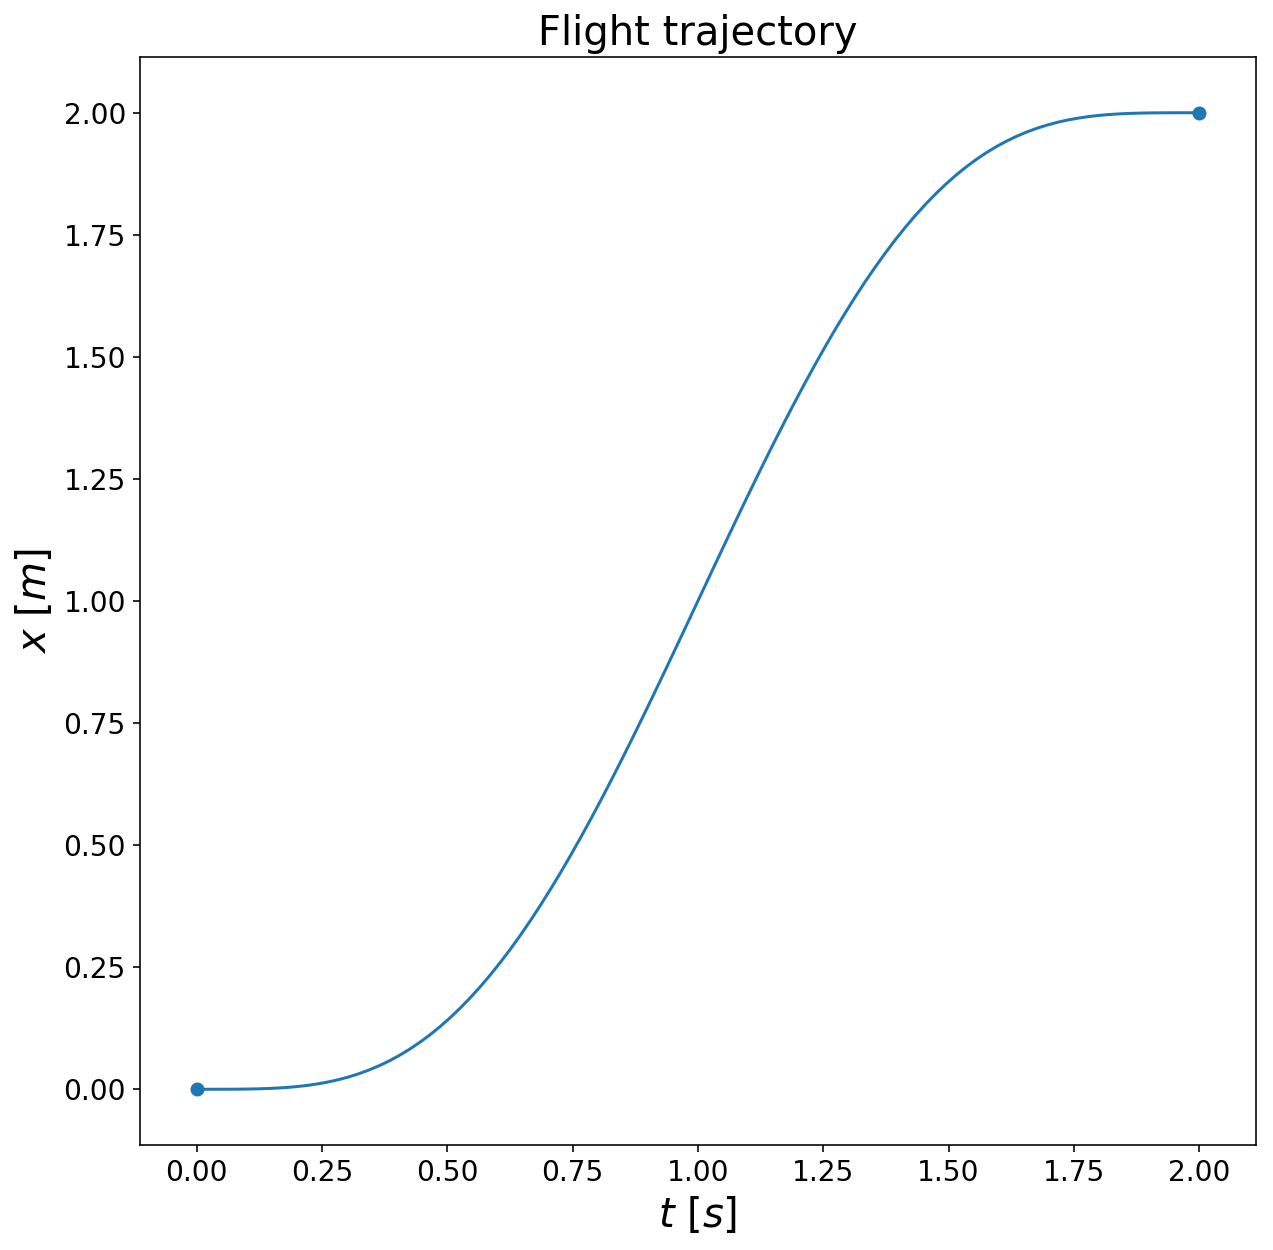

In [6]:
plt.plot(t,x)
plt.scatter([ts,te], [x[0], x[-1]])
plt.title('Flight trajectory').set_fontsize(20)
plt.xlabel('$t$ [$s$]').set_fontsize(20)
plt.ylabel('$x$ [$m$]').set_fontsize(20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

# Generating trajectory using multiple waypoints. 

Now we need to connect the boundary conditions along the intermediate points to solve the trajectory. Where the position is given we need to match the derivatives which are free.

For the first and the last points we will use the same set of boundary conditions (4 for the first one and 4 for the last one). For the rest of the waypoints we will be connecting the boundary conditions of two polynomials. 

Consider that we would like to match polynomial $i$ and $i+1$ at the point $P_{i+1}$. For this we will require to state that polynomial $i$ satisfies  $f_i(t) = P_{i+1}$ and polynomial $i+1$, $f_{i+1}(t) = P_{i+1}$.

Additionally two polynomials need to be differentiable along the boundary. $f_i(t)=f_{i+1}(t)$, $\dot{f}_i(t)=\dot{f}_{i+1}(t)$, $\ddot{f}_i(t)=\ddot{f}_{i+1}(t)$, ... , $f^{(6)}_i(t)=f^{(6)}_{i+1}(t)$. As the values of the derivatives are free and we do not assign them we can express this condition in the form of $f^{(n)}_i(t)-f^{(n)}_{i+1}(t) = 0$ where $n=[1,6]$. Thus this results in to 8 conditions (2 conditions for position and 6 for derivatives). 

Assume that we have m polynomials ($m+1$ points).
The coefficients of the polynomials are expressed as one long vector of $8 \times m$ elements. 

$$
\begin{pmatrix} c_{0-7}(1) \\ c_{0-7}(2) \\ ... \\ c_{0-7}(m-1) \\ c_{0-7}(m) \end{pmatrix}
$$

The conditions for the first polynomial will include 4 at the initial state and the 7 at the end (position at the end and the 6 derivatives). For all the intermediary polynomials we will have 7 conditions at the beginning (1 position and 6 the derivatives) and similarly 7 conditions at the end.  For the final polynomial, the boundary conditions are similar to the first polynomial except that they are reversed with 7 conditions at the beginning and 4 at the end. 

The right hand side will only contain the initial, final conditions $(x,\dot{x}, \ddot{x}, \dddot{x})$ and intermediate points $x_j$ $j =[1,m]$. All other elements are equal to zeros as we expressed the equality of the derivatives by substracting one side from another and equating them to zeros. The resulting linear equation will have the form of 

$$
M c = b .
$$

Where $c$ is the vector of our polynomial coefficients belonging to the $m$ curves, $b$ contains the initial, final and intermediary conditions. The $M$ matrix describes the relation between those coefficients. 


One important thing to keep in mind we will be parametrizing the curve in each section by the dimensionless time which goes from -1 to 1. This will help to maintain the $M$ matrix well defined and prevent the element value increase due to increase in time as the elements that it contains are $t^7$. 

The advantage of expressing the path in polynomial fashion is that the matrix has a well-defined form and it does not change from curve to curve. It only gets multiplied by different coefficients. 

In [7]:
def matrix_generation(ts):
    b =np.array([[1, ts,  ts**2, ts**3,    ts**4,    ts**5,    ts**6,    ts**7],
                 [0, 1 ,2*ts,  3*ts**2,  4*ts**3,  5*ts**4,  6*ts**5,  7*ts**6],
                 [0, 0 ,2,     6*ts,    12*ts**2, 20*ts**3, 30*ts**4, 42*ts**5],
                 [0, 0 ,0,     6,       24*ts,    60*ts**2,120*ts**3,210*ts**4],
                 [0, 0 ,0,     0,       24   ,   120*ts   ,360*ts**2,840*ts**3],
                 [0, 0 ,0,     0,       0    ,   120      ,720*ts  ,2520*ts**2],
                 [0, 0 ,0,     0,       0    ,   0        ,720     ,5040*ts   ],
                 [0, 0 ,0,     0,       0    ,   0        ,0       ,5040      ]])
    
    return b

Generating $M$ matrix

In [8]:
def multiple_waypoints(t):
    n= t.shape[0]-1
    
    m= np.zeros((8*n,8*n))
    
    for i in range(n):
    
        if i == 0:
            
            # initial condition of the first curve
            b = matrix_generation(-1.0)
            m[8*i:8*i+4,8*i:8*i+8] = b[:4,:]
            
            # intermidiary condition of the first curve
            b = matrix_generation(1.0)
            m[8*i+4:8*i+7+4,8*i:8*i+8] = b[:-1,:]
            
            # starting condition of the second curve position and derivatives 
            b = matrix_generation(-1.0)
            m[8*i+4+1:8*i+4+7,8*(i+1):8*(i+1)+8] = -b[1:-1,:]
            m[8*i+4+7:8*i+4+8,8*(i+1):8*(i+1)+8] = b[0,:]
            
        elif i!=n-1:
            
            # starting condition of the ith curve position and derivatives 
            b = matrix_generation(1.0)
            m[8*i+4:8*i+7+4,8*i:8*i+8] = b[:-1,:]
            
            # end condition of the ith curve position and derivatives 
            b = matrix_generation(-1.0)
            m[8*i+4+1:8*i+4+7,8*(i+1):8*(i+1)+8] = -b[1:-1,:]
            m[8*i+4+7:8*i+4+8,8*(i+1):8*(i+1)+8] = b[0,:]
        
        if i==n-1: 
            
            # end condition of the final curve position and derivatives (4 boundary conditions) 
            b = matrix_generation(1.0)
            m[8*i+4:8*i+4+4,8*i:8*i+8] = b[:4,:]
            
    return m 

Generating the right-hand side of the equation with boundary conditions and intermediary points. All other entries are equal to zero. For this exercise we assume the drone starts in a complete still position and comes to a complete stop at the end of the path. Thus $\dot{x}_s = 0, \ddot{x}_s = 0, \dddot{x}_s = 0$ and $\dot{x}_e = 0, \ddot{x}_e = 0, \dddot{x}_e = 0$.

In [9]:
def rhs_generation(x):
    n= x.shape[0]-1
    
    big_x = np.zeros((8*n))
    big_x[:4] = np.array([x[0],0,0,0]).T
    big_x[-4:] = np.array([x[-1],0,0,0]).T
    
    for i in range(1,n):
        big_x[8*(i-1)+4:8*(i-1)+8+4] = np.array([x[i],0,0,0,0,0,0,x[i]]).T
            
    return big_x

Declaring the points $x$ and the associated time $t$ at which they are reached. 
After defining position and time arrays we can generate the $M$ matrix and $b$ for which we can solve the $c$ vector containing unknown parameters.

In [10]:
t = np.array([0,1,2,3,4,5,6,7,8,9,10])
x = np.array([0,1,2,4,6,7,7.5,6.5,5,4.5,4.0])

m = multiple_waypoints(t)
b = rhs_generation(x)

coeff = coeff = np.linalg.solve(m,b)

Once we know how to express the curve between each point we can plot the continuous expression of the trajectory by fitting the polynomial of the known coefficients for the given dimensionless time. $\tau_{now}=(2*t_{now}-(t_{i+1}+t_{i}))/(t_{i+1}-t_i)$ which results in values of $\tau_{now}$ being between -1 and 1. 


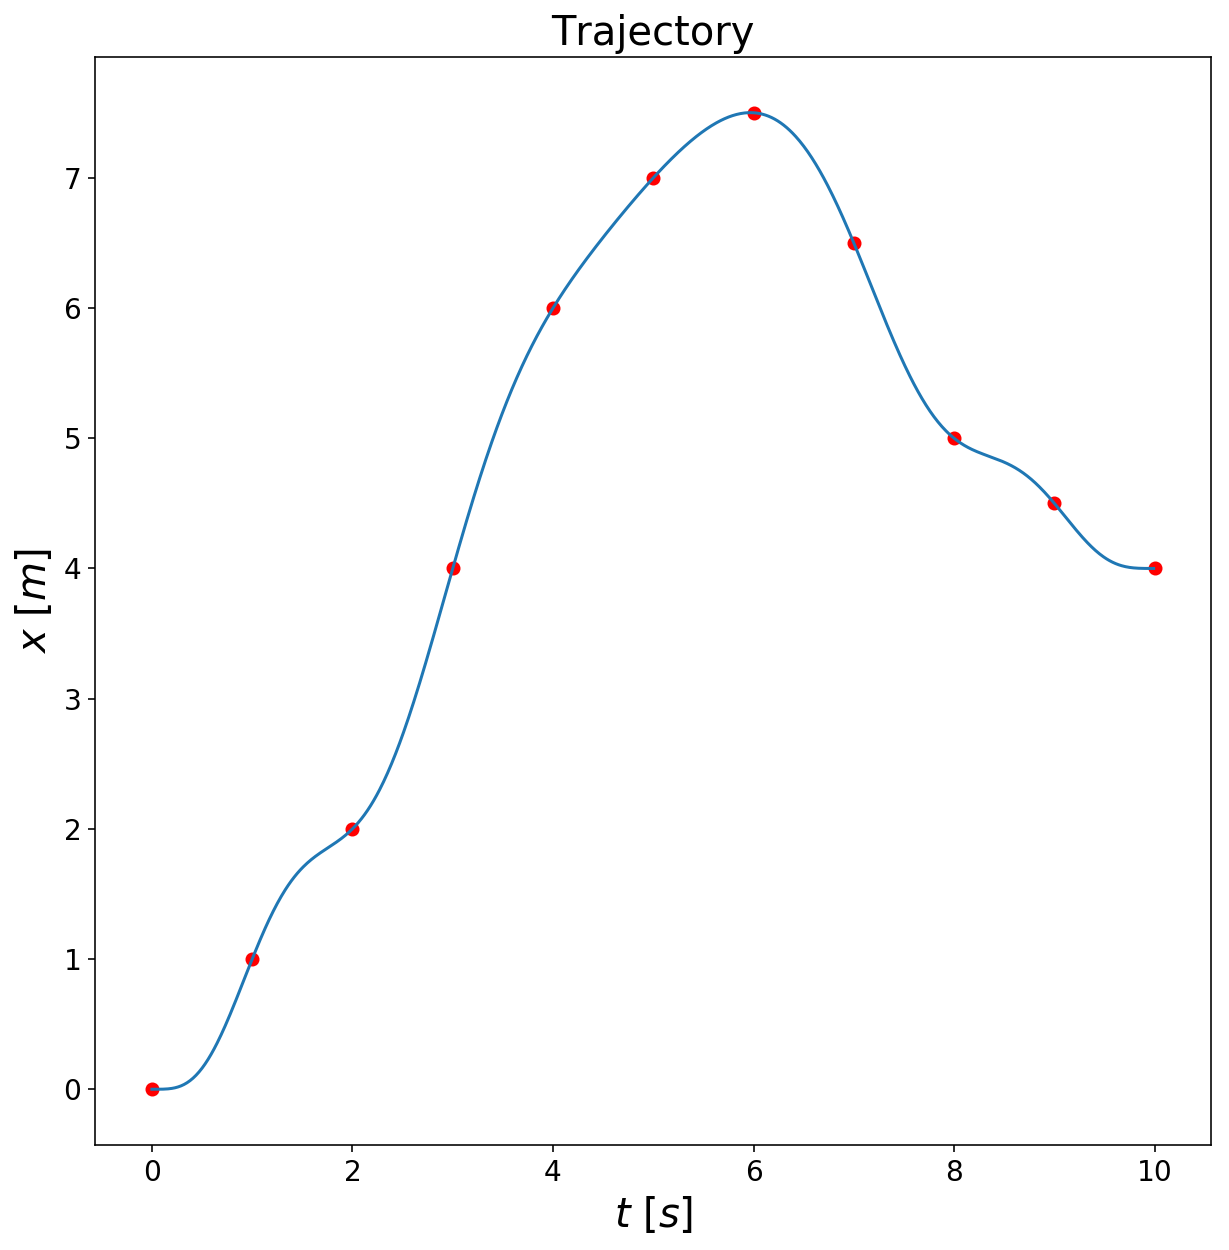

In [11]:
c = np.zeros((int(coeff.shape[0]/8),8))

for l in range(t.shape[0]-1):
    t1 = np.linspace(-1.0,1.0,101)
    x1 = np.zeros(t1.shape)
    
    c[l,:] = coeff[8*l:8*l+8]
        
    for i in range(t1.shape[0]):
        x1[i]=polyval(t1[i], c[l,:])
        
    if l ==0:
        xx= x1[:-1]
        tx= (t[l]+t[l+1])/2 + t1*(t[l+1]-t[l])/2
        tt= tx[:-1]
    else:
        xx=np.hstack((xx,x1[:-1]))
        tx= (t[l]+t[l+1] + t1*(t[l+1]-t[l]))/2
        tt=np.hstack((tt,tx[:-1]))

plt.plot(tt,xx)
plt.scatter(t,x,marker='o',color='red')
plt.title('Trajectory').set_fontsize(20)
plt.xlabel('$t$ [$s$]').set_fontsize(20)
plt.ylabel('$x$ [$m$]').set_fontsize(20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()


We also can plot the velocity $\dot{x}=v$, acceleration $\ddot{x}=a$, jerk $\dddot{x}=j$ and snap $\ddddot{x}=s$ to make sure that they are continious in time. 

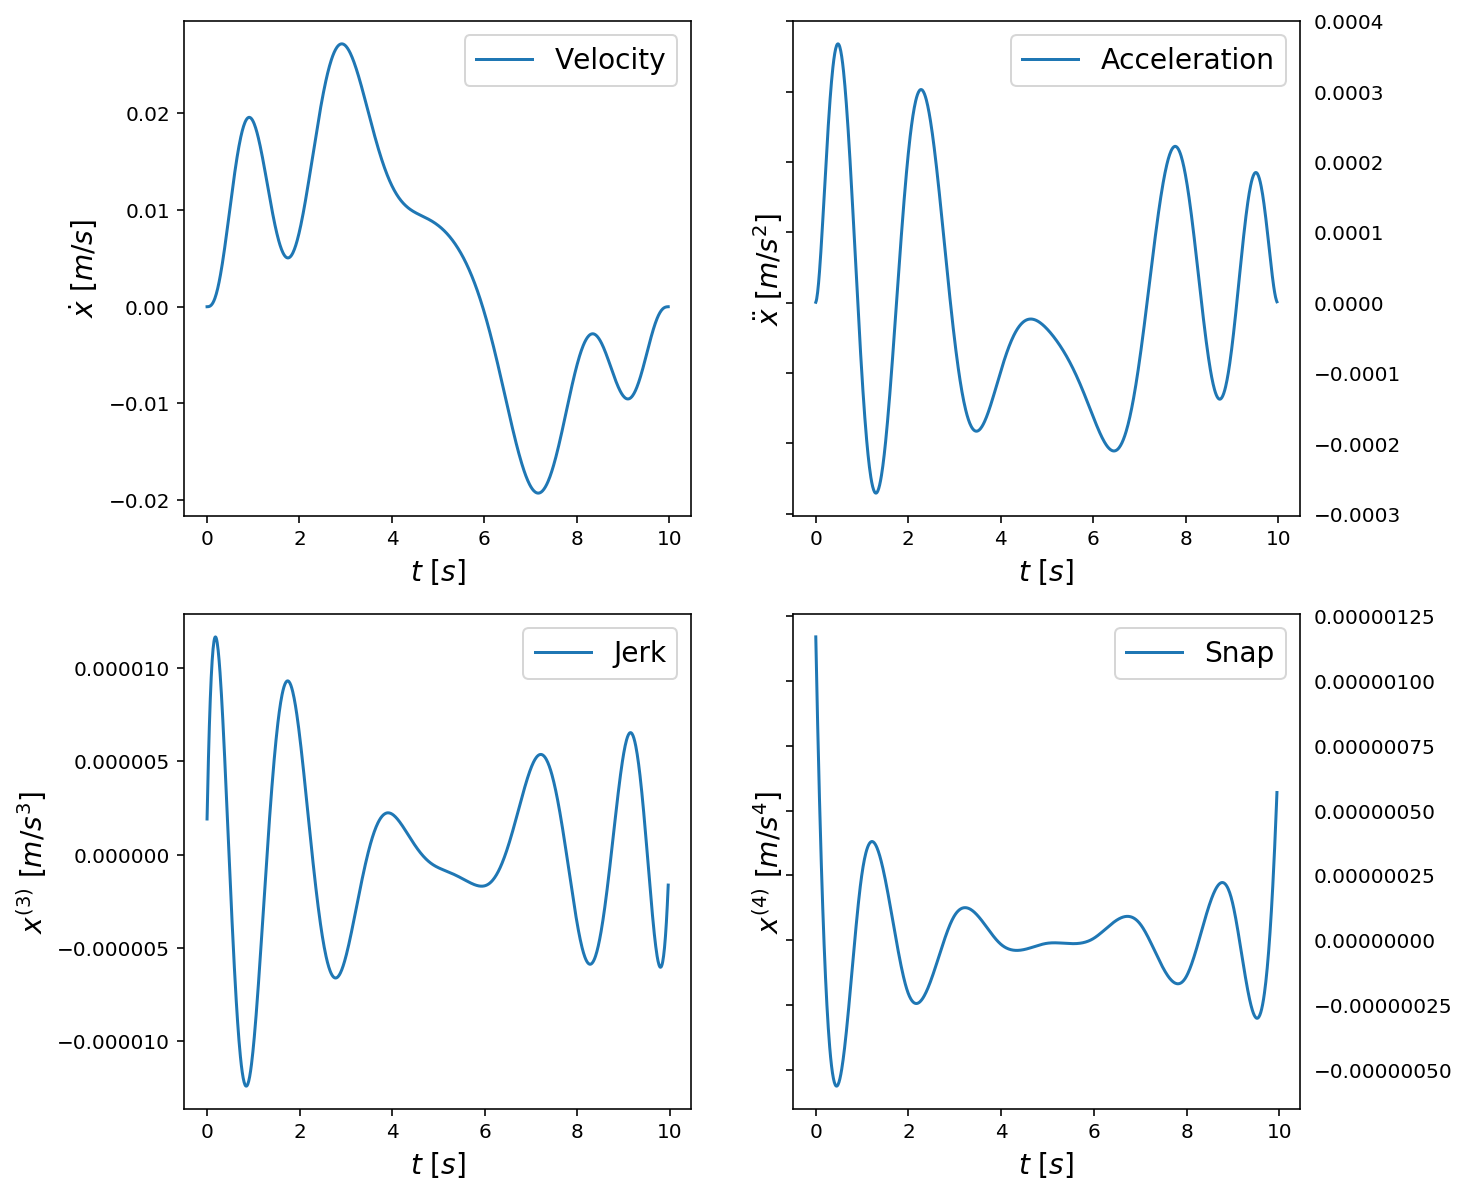

In [12]:
v = np.diff(xx)
a = np.diff(v)
j = np.diff(a)
s = np.diff(j)


plt.subplot(2,2,1)
plt.plot(tt[:-1],v)
plt.legend(['Velocity'],fontsize = 14)
plt.xlabel('$t$ [$s$]').set_fontsize(14)
plt.ylabel('$\dot{x}$ [$m/s$]').set_fontsize(14)

plt.subplot(2,2,2)
plt.plot(tt[:-2],a)
plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')
plt.legend(['Acceleration'],fontsize = 14)
plt.xlabel('$t$ [$s$]').set_fontsize(14)
plt.ylabel('$\ddot{x}$ [$m/s^2$]').set_fontsize(14)

plt.subplot(2,2,3)
plt.plot(tt[:-3],j)
plt.legend(['Jerk'],fontsize = 14)
plt.xlabel('$t$ [$s$]').set_fontsize(14)
plt.ylabel('$x^{(3)}$ [$m/s^3$]').set_fontsize(14)


plt.subplot(2,2,4)
plt.plot(tt[:-4],s)
plt.legend(['Snap'],fontsize = 14)
plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')
plt.xlabel('$t$ [$s$]').set_fontsize(14)
plt.ylabel('$x^{(4)}$ [$m/s^4$]').set_fontsize(14)

plt.show()

# Generalization into the 3D environment 

The parametrization of the path can be used for $x,y,z$ coordinates separately without worrying about interdependency. Thus we can use the code which we developed for all three coordinates seperately.  

We will express the point $p$ in space as the set of $x,y,z$ coordinates and use polynomial description and parameterize them separately. 

In [13]:
t = np.array([0,1,2,3,4,5])

p = np.array([[0,1,2,2,1.5,1.5,],
              [0,0,0,1,1.5,1.5,],
              [0,1,1,1,1.5,2.0,]])

m = multiple_waypoints(t)

b_x = rhs_generation(p[0,:])
b_y = rhs_generation(p[1,:])
b_z = rhs_generation(p[2,:])

coeff_x  = np.linalg.solve(m,b_x)
coeff_y  = np.linalg.solve(m,b_y)
coeff_z  = np.linalg.solve(m,b_z)

Plotting the flight path. 

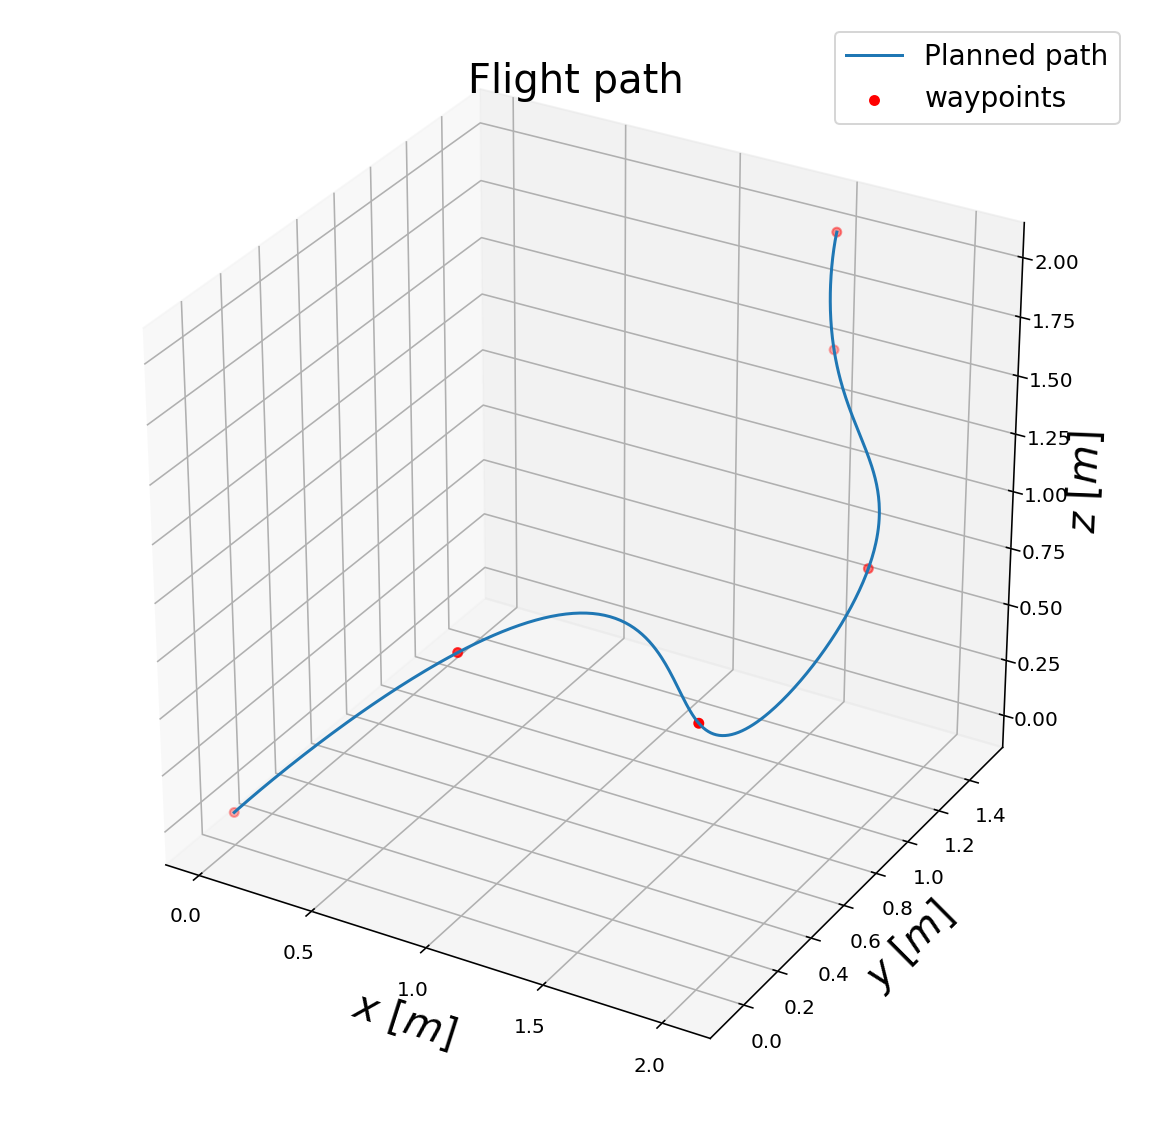

In [14]:
c_x = np.zeros((int(coeff_x.shape[0]/8),8))
c_y = np.zeros((int(coeff_x.shape[0]/8),8))
c_z = np.zeros((int(coeff_x.shape[0]/8),8))

t1 = np.linspace(-1.0,1.0,101)

for l in range(t.shape[0]-1):

    x1 = np.zeros(t1.shape)
    y1 = np.zeros(t1.shape)
    z1 = np.zeros(t1.shape)
    
    c_x[l,:] = coeff_x[8*l:8*l+8]
    c_y[l,:] = coeff_y[8*l:8*l+8]
    c_z[l,:] = coeff_z[8*l:8*l+8]
        
    for i in range(t1.shape[0]):
        x1[i]=polyval(t1[i], c_x[l,:])
        y1[i]=polyval(t1[i], c_y[l,:])
        z1[i]=polyval(t1[i], c_z[l,:])
        
    if l ==0:
        xx= x1[:-1]
        yy= y1[:-1]
        zz= z1[:-1]
        tx= (t[l]+t[l+1])/2 + t1*(t[l+1]-t[l])/2
        tt= tx[:-1]
    else:
        xx=np.hstack((xx,x1[:-1]))
        yy=np.hstack((yy,y1[:-1]))
        zz=np.hstack((zz,z1[:-1]))
        tx= (t[l]+t[l+1] + t1*(t[l+1]-t[l]))/2
        tt=np.hstack((tt,tx[:-1]))

        
fig = plt.figure() 
ax = fig.gca(projection='3d')
ax.plot(xx, yy, zz)
ax.scatter(p[0,:], p[1,:], p[2,:], marker ='o', color='red')

plt.title('Flight path').set_fontsize(20)
ax.set_xlabel('$x$ [$m$]').set_fontsize(20)
ax.set_ylabel('$y$ [$m$]').set_fontsize(20)
ax.set_zlabel('$z$ [$m$]').set_fontsize(20)
plt.legend(['Planned path','waypoints'],fontsize = 14)

plt.show()